In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import poisson

from qutip import *
import laser
import cnb
import entropy_utils

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1
%aimport laser, cnb, entropy_utils

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

## An example for CNB I and CNB II

In [4]:
# CNB I
N = 1600 # number of trapped bosons
kappa = 1.2e-7 # rate constant
TTc = 0.94 # T/T_c, where T_c is the critical temperature

init_psi = fock(N + 1, 0) # initial state

cnb1 = cnb.CNB(N, kappa, TTc, eta=0) # CNB I
cnb2 = cnb.CNB(N, kappa, TTc, eta=0.368) # CNB II

In [5]:
t_list = np.linspace(0, 600000, 1001)

print(str(datetime.now()))
cnb1.pn_evolve(init_psi, t_list)
print(str(datetime.now()))
cnb2.pn_evolve(init_psi, t_list)
print(str(datetime.now()))

2017-08-10 00:29:45.850364
2017-08-10 00:31:49.734444
2017-08-10 00:33:26.378368


In [6]:
n_dict = {'$\kappa t$': t_list * kappa}
entr_dict = {'$\kappa t$': t_list * kappa}
pn_dict = {'n': np.arange(N + 1)}

n_dict['CNB I'] = cnb1.get_ns()
n_dict['CNB II'] = cnb2.get_ns()
entr_dict['CNB I'] = cnb1.get_entrs()
entr_dict['CNB II'] = cnb2.get_entrs()
pn_dict['CNB I'] = cnb1.get_pns()[-1]
pn_dict['CNB II'] = cnb2.get_pns()[-1]

n_df = pd.DataFrame(n_dict, columns=n_dict.keys())
entr_df = pd.DataFrame(entr_dict, columns=entr_dict.keys())
pn_df = pd.DataFrame(pn_dict, columns=pn_dict.keys())

In [7]:
n_df.to_csv('./data/n_df.csv', index=False)
entr_df.to_csv('./data/entr_df.csv', index=False)
pn_df.to_csv('./data/pn_df.csv', index=False)

### Setup

- Number of Bosons: N = 1600
- Temperature: T/T_c = 0.94
- Rate Constant: kappa = 1.2e-7
- Cross Excitation Parameters for CNB II: eta = 0.368

### Results

In [8]:
n_df = pd.read_csv('./data/n_df.csv')
entr_df = pd.read_csv('./data/entr_df.csv')
pn_df = pd.read_csv('./data/pn_df.csv')

#### Avergae Boson Numbers vs. Time

In [9]:
print(n_df['CNB I'][1000]) # average photon numberof stable state
print(n_df['CNB II'][1000]) # average photon numberof stable state

271.064636583
271.064669145


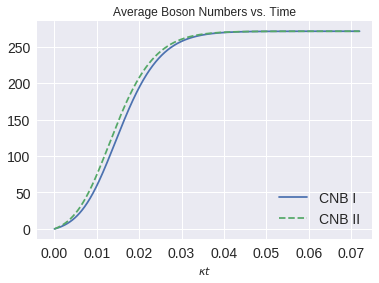

In [10]:
n_df.plot(x='$\kappa t$', xlim=(-0.004, 0.075), 
          figsize=(6, 4), fontsize=14, style=['-', '--'])
plt.legend(fontsize=14, loc=4)
plt.title("Average Boson Numbers vs. Time")

#### Entropy vs. Time

In [11]:
print(entr_df['CNB I'][1000]) # average photon numberof stable state
print(entr_df['CNB II'][1000]) # average photon numberof stable state

5.01495229652
5.17155037363


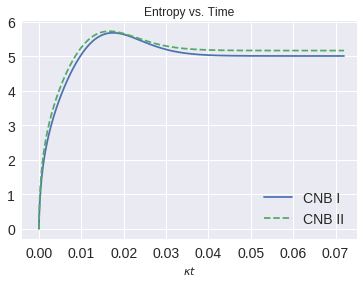

In [12]:
entr_df.plot(x='$\kappa t$', xlim=(-0.004, 0.075), 
             figsize=(6, 4), fontsize=14, style=['-', '--'])
plt.legend(fontsize=14, loc=4)
plt.title("Entropy vs. Time")

#### Probability Distribution of Stable State

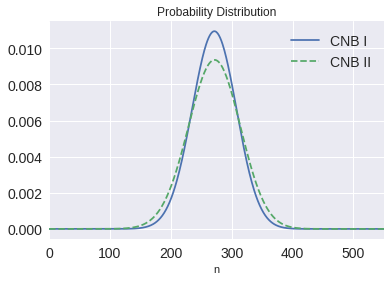

In [13]:
pn_df.plot(x='n', xlim=(0, 550), 
           figsize=(6, 4), fontsize=14, style=['-', '--'])
plt.legend(fontsize=14, loc=1)
plt.title("Probability Distribution")

In [14]:
def plot_photon_statistics_evolution(l, gts, title, x1, x2, y1, y2):
    """ plot photon statistics with respect to time
        l: laser object
        gts: time point to be plotted, [1, 100]
        title: figure title
        x1, x2: xlim
        y1, y2: ylim
    """
    N_max = l.N_max
    lstyle = ['-', '--', ':', '-.', '-', '--']
    lwidth = [1, 2, 2, 2, 2, 2]
    fig, ax = plt.subplots(sharex=True, figsize=(12, 4))
    t_list = l.t_list
    pns_all = l.get_pns()

    for i in range(len(gts)):
        print (i)
        pns = pns_all[gts[i]]
        ax.plot(np.arange(N_max), pns, \
                linestyle=lstyle[i], linewidth=lwidth[i], \
                label='{:4.2f}'.format(t_list[gts[i]]))
        
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    ax.set_xlabel(r'$n$', fontsize=14)
    ax.set_ylabel(r'$p_n$', fontsize=14)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    plt.title(title, fontsize=14);

0
1
2
3
4


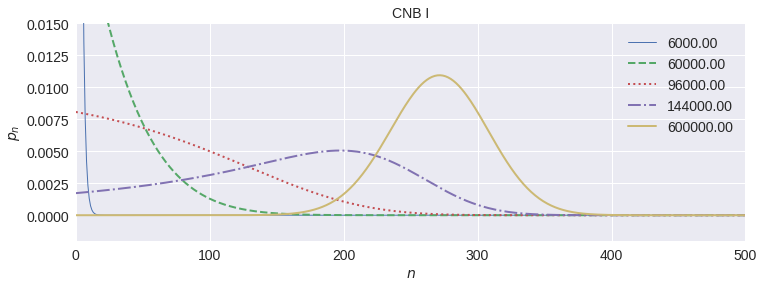

In [15]:
plot_photon_statistics_evolution(cnb1, (10, 100, 160, 240, 1000), \
                                 r'CNB I', 0, 500, -0.002, 0.015)

0
1
2
3
4


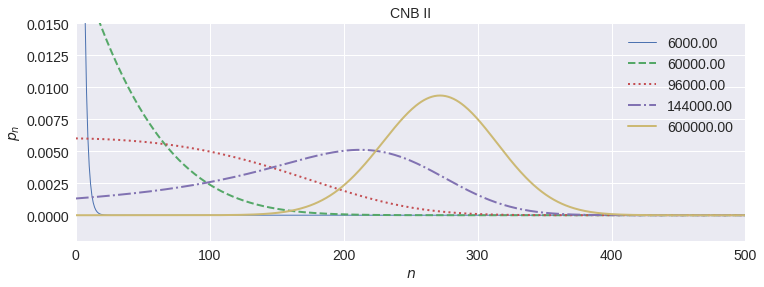

In [16]:
plot_photon_statistics_evolution(cnb2, (10, 100, 160, 240, 1000), \
                                 r'CNB II', 0, 500, -0.002, 0.015)

### Approximation of Entropy

In [17]:
from scipy.special import erfc
def calc_entr_vec(mean, varn):
    """ Calculate the vector of entropy 
        given on the vector of the mean and the variance
    """
    result = np.log(np.sqrt(2.0 * np.pi * varn)) + 0.5
    result +=  np.log(0.5 * erfc(- mean / np.sqrt(2.0 * varn)))
    nn = - mean * np.exp(- mean**2 / 2.0 / varn) 
    dd = np.sqrt(2.0 * np.pi * varn) * erfc(- mean / np.sqrt(2.0 * varn))
    result += nn / dd
    result = np.insert(result, 0, 0)
    return result

def get_entr_approx(cnb_state):
    pns_all = cnb_state.get_pns()[1:]
    mean_all = np.array(cnb_state.get_ns())[1:]
    N_max = cnb_state.N_max
    
    var_n_all = []
    for pns in pns_all:
        aver_n = sum([pns[i] * i for i in range(N_max)])
        aver_n2 = sum([pns[i] * i**2 for i in range(N_max)])
        var_n_all.append(aver_n2 - aver_n**2)
       
    result = calc_entr_vec(mean_all, np.array(var_n_all))
    result[result < 0] = 0
    return result

In [33]:
entr_df['I Approx'] = get_entr_approx(cnb1)
entr_df['II Approx'] = get_entr_approx(cnb2)
entr_df.to_csv('./data/entr_df.csv', index=False)

In [34]:
# CNB I
H = N * TTc**3
mean = N - H
eta = 0.386
var1 = H
var2 = H * (1 + eta)
mean, var1, var2

(271.06560000000013, 1328.9343999999999, 1841.9030784)

In [35]:
calc_entr_vec(mean, var1), calc_entr_vec(H, var1)

(0.0, 0.0)

In [36]:
calc_entr_vec(mean, var2), calc_entr_vec(H, var2) 

(0.0, 0.0)

In [37]:
np.log(np.sqrt(2 * np.pi * H)) + 0.5

5.0150048817414774

In [38]:
print(entr_df['CNB I'][1000]) # average photon numberof stable state
print(entr_df['CNB II'][1000]) # average photon numberof stable state

5.01495229652
5.17155037363


In [39]:
def plot_varn_entr(df, state, approx, start, end):
    fig, ax = plt.subplots()
    t_list = df['$\kappa t$'][start:end]
    entr = df[state][start:end]
    entr_approx = df[approx][start:end]
    
    ax.plot(t_list, entr_approx, linestyle='--', label='Gaussian entropy')
    ax.plot(t_list, entr, linestyle='-', label ='numeric entropy')
    ax.plot(t_list, entr - entr_approx, linestyle='-.', label ='difference')
    ax.legend(fontsize=14, loc=4)
    ax.set_title("Entropy for " + state)

In [41]:
entr_df.head()

,$\kappa t$,CNB I,CNB II,I Approx,II Approx
0,0.000000,-0.000000,-0.000000,0.000000,0.000000
1,0.000072,0.373095,0.463648,0.000000,0.027312
2,0.000144,0.600854,0.733010,0.279221,0.491628
3,0.000216,0.780403,0.940080,0.562744,0.788174
4,0.000288,0.931491,1.111235,0.776500,1.011894


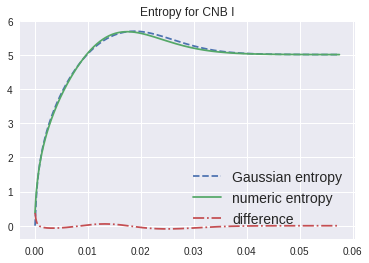

In [42]:
plot_varn_entr(entr_df, 'CNB I', 'I Approx', 1, 800)

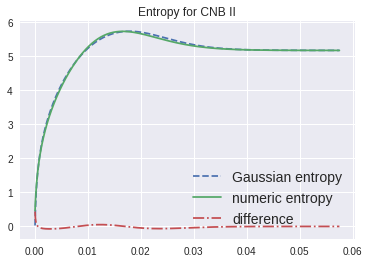

In [43]:
plot_varn_entr(entr_df, 'CNB II', 'II Approx', 1, 800)